# Análise dos dados dos filmes disponíveis no IMDB 

Esse projeto foi desenvolvido durante o curso de Python Fundamentos Para Análise de Dados 3.0 da DataScience Academy. O foco aqui foi usar, pela primeira vez, a linguagem SQL para consultar o banco de dados e trazer o resultado já agrupado previamente, de modo a responder perguntas como:
- Categoria de filmes mais comuns;
- Mediana e quantidade de notas dos filmes;
- Relação entre a duração e gênero do filme;
- Quais países mais lançaram filmes até o momento;
- Top 10 melhores e piores filmes de acordo com a nota no IMDB;

Os dados utilizados foram obtidos diretamente do IMDB, conforme mostrado, em julho de 2022. Ao repetir a análise posteriormente pode haver diferenças nos resultados pois o banco de dados é atualizado diariamente. 

## Instalação, imports e download do dataset 

In [1]:
#instalação de pacotes para baixar dados do imdb para banco de dados e de nome dos paises
!pip install -q imdb-sqlite
!pip install -q pycountry

In [2]:
# Imports
import re #expressões regulares
import time #tempo de execução, datas
import sqlite3 #manipular banco de dados
import pycountry #manipular nome de paises
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer #criar vetor para alguns calculos
import warnings #filtrar os erros
warnings.filterwarnings("ignore")


In [3]:
#baixa dados diretamente do site
!imdb-sqlite 

2022-07-19 10:30:05,527 DB already exists: (imdb.db). Refusing to modify. Exiting


In [4]:
# conecta ao bando de dados
conn = sqlite3.connect('imdb.db')

In [5]:
#Extrai a lista de tabelas
tabelas = pd.read_sql_query("SELECT NAME AS 'Table_Name' FROM sqlite_master WHERE type ='table'", conn)

In [6]:
#Verificando o tipo
type(tabelas)

pandas.core.frame.DataFrame

In [7]:
#visualizando as tabelas
tabelas.head()

,Table_Name
0,people
1,titles
2,akas
3,crew
4,episodes


In [8]:
#Convertendo dataframe para lista
tabelas = tabelas["Table_Name"].values.tolist()

In [9]:
#Percorrendo a lista de tabelas e extraindo o esquema de cada uma (colunas, tipo de dados, se aceita nulo, chave primária)
for tabela in tabelas:
  consulta = 'PRAGMA TABLE_INFO({})'.format(tabela)
  resultado = pd.read_sql_query(consulta, conn)
  print("Esquema da tabela:", tabela)
  display(resultado)
  print('-'*100)
  print('\n')

Esquema da tabela: people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------




Temos 6 tabelas separadas, cada uma com dados distintos mas relacionados.
- A tabela PEOPLE traz os dados sobre pessoas relacionadas a obra, com nome, nascimento e, caso seja o caso, data do falecimento;
- Em TITLES estão informações sobre as obras lançadas, informando o título, ano de estreia, tipo, gênero, e, nos casos aplicáveis, ano de encerramento;
- AKAS contém as informações sobre o título em línguas diferentes da original; 
- A tabela CREW contém dados sobre os atores principais das obras; 
- EPISODES são dados das séries lançadas, com nome e quantidade de episódios e temporadas;
- Em RATINGS estão os dados das notas, tanto em valor atribuído e quantidade. 

## Análise exploratória dos dados

### 1- Quais são as categorias mais comuns no IMDB?

In [10]:
# Fazendo a consulta no SQL
consulta1 = '''SELECT type, COUNT(*) AS COUNT FROM titles GROUP BY type'''

#extraindo o resultado
resultado1 = pd.read_sql_query(consulta1, conn)

#Visualizando o resultado
resultado1.sort_values(by='COUNT', ascending=False, inplace = True )
resultado1

,type,COUNT
2,tvEpisode,6804680
1,short,877623
0,movie,614555
9,video,262455
6,tvSeries,227619
4,tvMovie,136673
3,tvMiniSeries,44142
8,tvSpecial,37541
10,videoGame,31527
7,tvShort,10602


In [11]:
#Adicionando coluna com o percentual
resultado1['Percentual (%)'] = ((resultado1['COUNT'] / resultado1['COUNT'].sum()) *100).round(2)
resultado1

,type,COUNT,Percentual (%)
2,tvEpisode,6804680,75.21
1,short,877623,9.70
0,movie,614555,6.79
9,video,262455,2.90
6,tvSeries,227619,2.52
4,tvMovie,136673,1.51
3,tvMiniSeries,44142,0.49
8,tvSpecial,37541,0.41
10,videoGame,31527,0.35
7,tvShort,10602,0.12


In [12]:
#Criando um grupo com 4 categorias: os top 3 + uma quarta com o restante
#dicionario vazio para adicionar o tipos gerais:
others = {}

#Filtra quantidade dos tipos com percentual de até 5%
others['COUNT'] = resultado1[resultado1['Percentual (%)'] <5]['COUNT'].sum()

#Soma dos percentuais 
others['Percentual (%)'] = resultado1[resultado1['Percentual (%)'] <5]['Percentual (%)'].sum()

# Ajusta o nome
others['type'] = 'others'

others

{'COUNT': 750561, 'Percentual (%)': 8.3, 'type': 'others'}

In [13]:
#Filtra os top 3 
top_types = resultado1[resultado1['Percentual (%)'] > 5]

In [14]:
#append com o dataframe others
top_types = top_types.append(others, ignore_index = True)

In [15]:
#Ordenando resultado
top_types.sort_values(by = 'COUNT', ascending = False, inplace = True)
top_types

,type,COUNT,Percentual (%)
0,tvEpisode,6804680,75.21
1,short,877623,9.70
3,others,750561,8.30
2,movie,614555,6.79


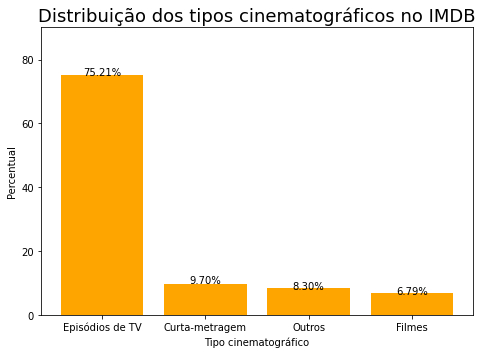

In [16]:
#plotando o gráfico para melhor visualização

labels = ('Episódios de TV', 'Curta-metragem', 'Outros', 'Filmes')
# Cria a figura
fig = plt.figure()
eixo = fig.add_axes([0,0,1,1])
eixo.grid(False)
#Plotando o gráfico
eixo.bar(top_types['type'], top_types['Percentual (%)'], color = 'orange')
#Adicionando legendas e rótulos
eixo.set_xticklabels(labels)
eixo.set_title('Distribuição dos tipos cinematográficos no IMDB', fontsize = 18)
eixo.set_ylabel('Percentual')
eixo.set_xlabel('Tipo cinematográfico')
eixo.set_ymargin(.2)
#Adicionando o valor de cada coluna
x= np.arange(len(top_types))
y = [76, 11, 9, 7.5]
z = ['75.21%', '9.70%', '8.30%', '6.79%']
for x, y, z in zip(x,y,z):
  plt.annotate(z, xy=(x,y), ha='center', va='center')

plt.show()

Nesse caso foi contado cada episódio separadamente, não a série unicamente, por isso a disparada diferença na quantidade entre outros tipos.

### 2- Qual a quantidade de títulos por gênero?

In [17]:
#Consultando no SQL
consulta2 = '''SELECT genres, COUNT(*) FROM titles WHERE type = 'movie' GROUP BY genres''' 

#Lendo o resultado
resultado2 = pd.read_sql_query(consulta2, conn)
resultado2

,genres,COUNT(*)
0,Action,14095
1,"Action,Adult",11
2,"Action,Adult,Adventure",1
3,"Action,Adult,Comedy",5
4,"Action,Adult,Crime",10
...,...,...
1463,"Thriller,Western",43
1464,War,1301
1465,"War,Western",14
1466,Western,5115


No banco de dados possui mais de uma entrada de genero por filme, gerando linhas desnecessárias e que podem atrapalhar a análise. 
Necessário a separação por gênero único e remoção de entradas ausentes

In [18]:
#convertendo string para minusculo para melhor execução
resultado2.genres = resultado2.genres.str.lower().values

In [19]:
#Removendo valores ausentes (NA)
temp = resultado2.genres.dropna()

Os valores unicos dos gêneros serão obtidos com o Countvectorizer

In [20]:
#Criando vetor com expressão regular para filtrar strings

padrao = '(?u)\\b[\\w-]+\\b'

vetor = CountVectorizer(token_pattern = padrao, analyzer = 'word').fit(temp)

In [21]:
# Aplica a vetorização ao dataset sem valores NA
bag_generos = vetor.transform(temp)

In [22]:
# Retorna gêneros únicos
generos_unicos =  vetor.get_feature_names()

In [23]:
# Transformando em dataframe
generos = pd.DataFrame(bag_generos.todense(), columns = generos_unicos, index = temp.index)

In [24]:
generos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1468 entries, 0 to 1467
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   action       1468 non-null   int64
 1   adult        1468 non-null   int64
 2   adventure    1468 non-null   int64
 3   animation    1468 non-null   int64
 4   biography    1468 non-null   int64
 5   comedy       1468 non-null   int64
 6   crime        1468 non-null   int64
 7   documentary  1468 non-null   int64
 8   drama        1468 non-null   int64
 9   family       1468 non-null   int64
 10  fantasy      1468 non-null   int64
 11  film-noir    1468 non-null   int64
 12  game-show    1468 non-null   int64
 13  history      1468 non-null   int64
 14  horror       1468 non-null   int64
 15  music        1468 non-null   int64
 16  musical      1468 non-null   int64
 17  mystery      1468 non-null   int64
 18  n            1468 non-null   int64
 19  news         1468 non-null   int64
 20  reality-

In [25]:
#deletando coluna 'n'
generos = generos.drop(columns = 'n', axis = 0)

In [26]:
#Calculando o percentual
generos_percentual = 100 * pd.Series(generos.sum()).sort_values(ascending = False)/generos.shape[0]
generos_percentual.head(10)

drama          17.915531
comedy         16.961853
documentary    15.803815
adventure      14.918256
action         14.509537
romance        13.283379
crime          13.010899
mystery        12.397820
thriller       12.261580
horror         12.193460
dtype: float64

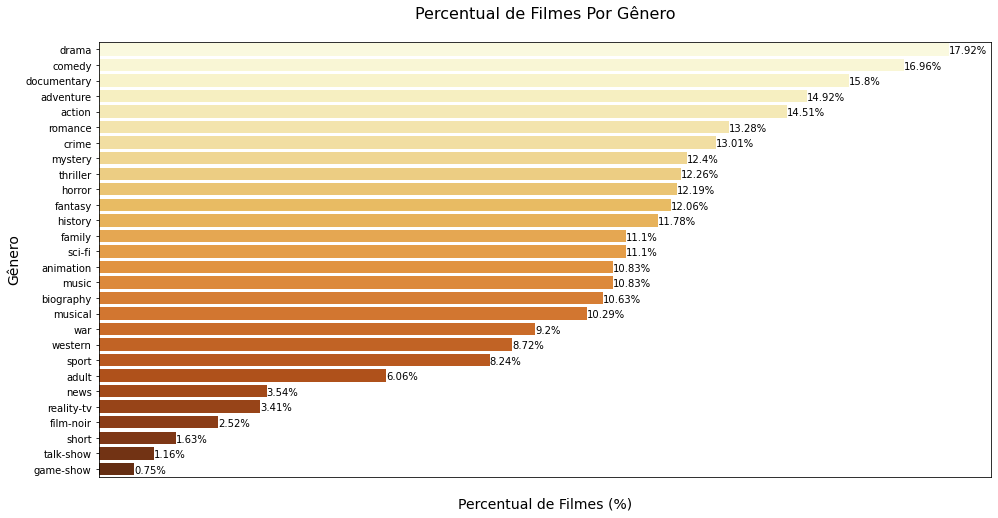

In [27]:
#plotando o gráfico
plt.figure(figsize = (16,8))
sns.barplot(x = generos_percentual.values, y = generos_percentual.index, orient = 'h', palette ='YlOrBr')
for i in range (len(generos_percentual)):
  plt.text(generos_percentual.values[i],
             i + 0.25, str(round(generos_percentual.values[i], 2)) + "%"
             )
plt.ylabel('Gênero', fontsize = 14)             
plt.xlabel("\nPercentual de Filmes (%)", fontsize = 14)
plt.title('Percentual de Filmes Por Gênero\n', fontsize = 16)
plt.xticks([]) 
plt.show()

Cada filme pode ser marcado com até 3 gêneros, nessa contagem foi separado cada gênero da lista e contado individualmente. Assim, drama foi o gênero mais atribuído as obras, seguido por comédia e documentário. 
Mistério, thriller e horror possui quantidades bem similares, e são gêneros que podem ser atribuídos ao mesmo filme, o mesmo acontece com animação e musical.  

### 3- Qual a mediana de avaliação dos filmes por gênero?

Usaremos a mediana para valor não ser tão afetado por outliers.

In [28]:
#Consultando o SQL
consulta3 = '''
            SELECT rating, genres FROM 
            ratings JOIN titles ON ratings.title_id = titles.title_id 
            WHERE premiered <= 2022 AND type = 'movie'
            ''' 

#resultado
resultado3 = pd.read_sql_query(consulta3, conn)
resultado3

,rating,genres
0,4.5,\N
1,6.0,"Action,Adventure,Biography"
2,4.7,Drama
3,4.5,Drama
4,3.9,Drama
...,...,...
280296,5.8,Thriller
280297,6.4,"Drama,History"
280298,3.8,"Adventure,History,War"
280299,8.3,Drama


In [29]:
#Criando função para retornar os genêros
def retorna_generos(df):
  df.genres = df.genres.str.lower().values
  temp = df.genres.dropna()
  vetor = CountVectorizer(token_pattern = '(?u)\\b[\\w-]+\\b', analyzer ='word').fit(temp)
  generos_unicos = vetor.get_feature_names()
  generos_unicos = [genre for genre in generos_unicos if len(genre) > 1]
  return generos_unicos


In [30]:
generos_unicos = retorna_generos(resultado3)
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [31]:
#Criando listas vazias
genero_counts = []
genero_ratings = []

In [32]:
# Loop
for item in generos_unicos:
    
    # Retorna a contagem de filmes por gênero
    consulta = 'SELECT COUNT(rating) FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_counts.append(resultado.values[0][0])
  
     # Retorna a avaliação de filmes por gênero
    consulta = 'SELECT rating FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_ratings.append(np.median(resultado['rating']))

In [33]:
#Montando dataframe final
df_genero_ratings = pd.DataFrame()
df_genero_ratings['genres'] = generos_unicos
df_genero_ratings['count'] = genero_counts
df_genero_ratings['rating'] = genero_ratings 

In [34]:
df_genero_ratings.sort_values(by= 'rating', ascending = False, inplace = True)
df_genero_ratings.head()

,genres,count,rating
18,news,660,7.3
7,documentary,42015,7.3
22,short,22,7.1
4,biography,8556,7.0
13,history,7756,6.9


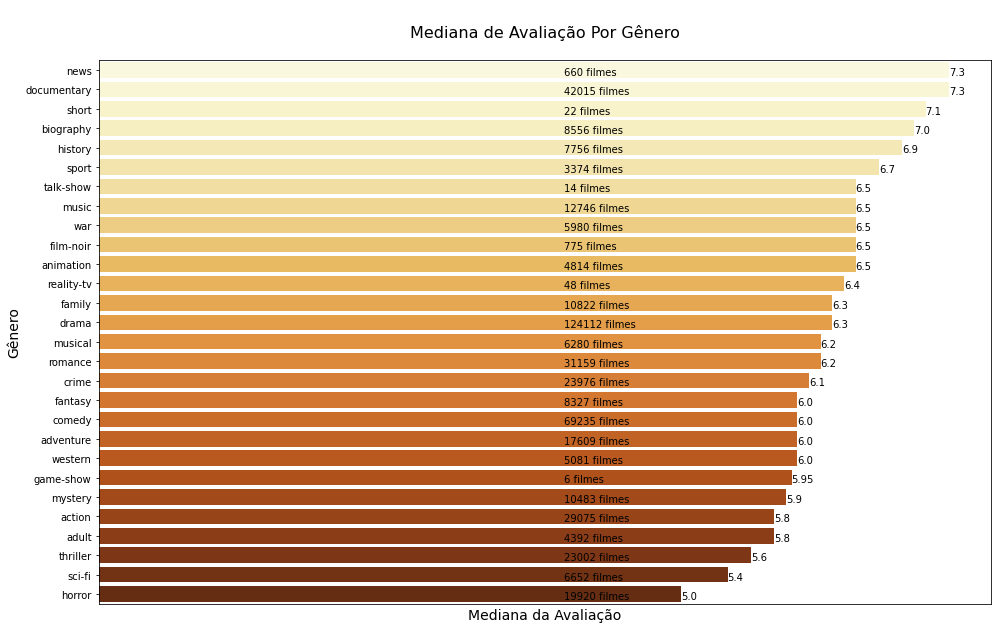

In [35]:
#plotando o gráfico
plt.figure(figsize=(16,10))

sns.barplot(y=df_genero_ratings.genres, x = df_genero_ratings.rating, orient = 'h', palette ='YlOrBr')

for i in range (len(df_genero_ratings.index)):
  plt.text(4.0, i+0.25, str(df_genero_ratings['count'][df_genero_ratings.index[i]]) + " filmes")
  plt.text(df_genero_ratings.rating[df_genero_ratings.index[i]],
             i + 0.25,
             round(df_genero_ratings["rating"][df_genero_ratings.index[i]],2))
plt.ylabel('Gênero', fontsize = 14)             
plt.xlabel('Mediana da Avaliação', fontsize = 14)
plt.title('\nMediana de Avaliação Por Gênero\n',fontsize = 16)
plt.xticks([]) 
plt.show()

O gênero News está associado a documentário no dataset, sendo comum a obra está marcada com os dois gêneros. 
Assim documentário é o gênero com maior mediana de notas, seguido de shorts e biografias. 
Drama e comédia, que são alguns dos gêneros mais comuns, estão no meio do rank de notas. 

### 4- Qual a mediana de avaliação dos filmes em relação ao ano de estreia?

In [36]:
#Consulta SQL
consulta4 = ''' SELECT rating AS Rating, premiered FROM ratings JOIN titles ON ratings.title_id = titles.title_id WHERE premiered <= 2022 AND type = 'movie' ORDER BY premiered'''

#resultado
resultado4 = pd.read_sql_query(consulta4, conn)
resultado4

,Rating,premiered
0,6.7,1896
1,4.5,1897
2,4.0,1899
3,3.7,1899
4,6.0,1900
...,...,...
280296,9.5,2022
280297,7.7,2022
280298,6.8,2022
280299,5.0,2022


In [37]:
#Calculando mediana ao longo dos anos
ratings = []
for year in set(resultado4['premiered']):
  ratings.append(np.median(resultado4[resultado4['premiered'] == year]['Rating']))

In [38]:
#Lista de anos
anos = list(set(resultado4['premiered']))

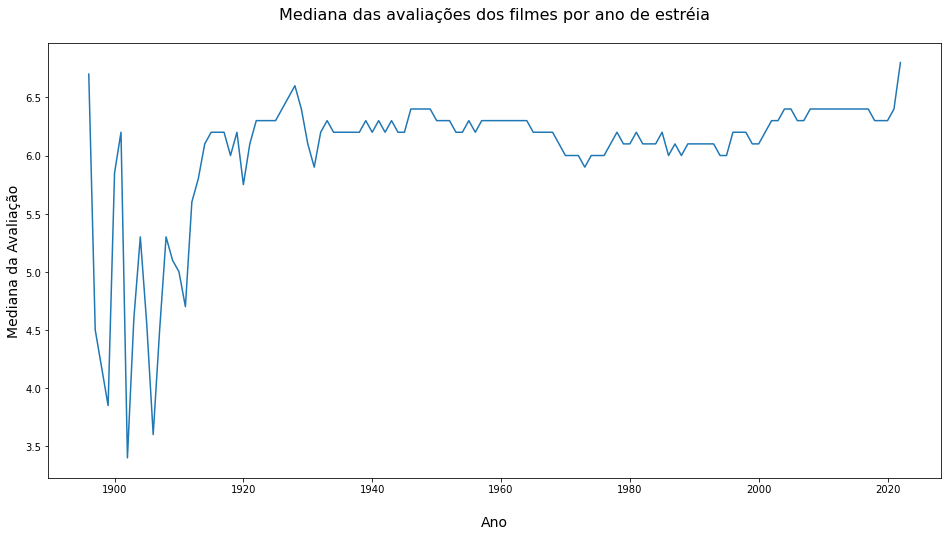

In [39]:
#plotando gráfico

plt.figure(figsize = (16 ,8))
plt.plot(anos, ratings)
plt.xlabel('\nAno', fontsize = 14)
plt.ylabel('Mediana da Avaliação', fontsize = 14)
plt.title('Mediana das avaliações dos filmes por ano de estréia\n',fontsize = 16)
plt.show()

A grande flutuação das notas nos filmes antigos pode ser pela pouca quantidade lançada, então cada nota individual tem um peso maior. Como são filmes velhos, alguns podem estar bem datados, levando a uma avaliação ruim. Entretanto, algumas obras podem ter um peso maior na história do que em efeitos visuais, por exemplo, levando a boa avaliação mesmo após tanto tempo.
As obras mais recentes tiveram notas mais homogêneas, tendo um grande crescimento de 2020 a atualmente. 

### 5- Qual o número de filmes avaliados por gênero em relação ao ano de estreia?

In [40]:
#Consulta SQL
consulta5 = ''' SELECT genres FROM titles'''

#Resultado
resultado5 = pd.read_sql_query(consulta5, conn)
resultado5

,genres
0,"Documentary,Short"
1,"Animation,Short"
2,"Animation,Comedy,Romance"
3,"Animation,Short"
4,"Comedy,Short"
...,...
9047414,"Action,Drama,Family"
9047415,"Action,Drama,Family"
9047416,"Action,Drama,Family"
9047417,Short


In [41]:
#Usando função anterior para pegar os generos unicos
generos_unicos = retorna_generos(resultado5)
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [42]:
#Contagem dos generos
genero_count = []
for item in generos_unicos:
    consulta = 'SELECT COUNT (*) COUNT FROM titles WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND premiered <= 2022'
    resultado = pd.read_sql_query(consulta, conn)
    genero_count.append(resultado['COUNT'].values[0])

In [43]:
#Prepara o dataframe
df_genero_count = pd.DataFrame()
df_genero_count['genre'] = generos_unicos
df_genero_count['Count'] = genero_count

In [44]:
#Calcula os top 5
df_genero_count = df_genero_count[df_genero_count['genre'] != 'n']
df_genero_count = df_genero_count.sort_values(by = 'Count', ascending = False)
top_generos = df_genero_count.head(5)['genre'].values

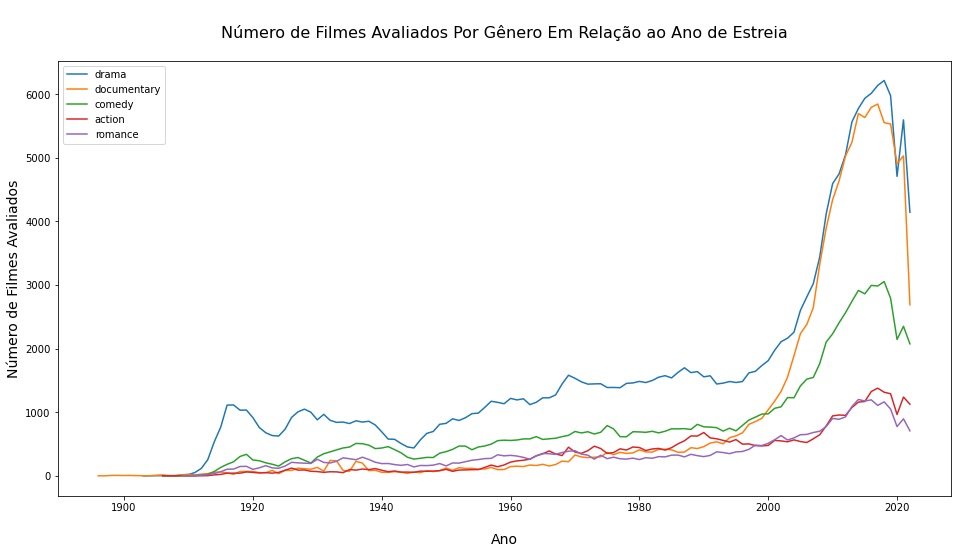

In [45]:
#plotando gráfico
plt.figure(figsize = (16,8))

# Loop e Plot
for item in top_generos:
    consulta = 'SELECT COUNT(*) Number_of_movies, premiered Year FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND Year <=2022 GROUP BY Year'
    resultado = pd.read_sql_query(consulta, conn)
    plt.plot(resultado['Year'], resultado['Number_of_movies'])

plt.xlabel('\nAno', fontsize = 14)
plt.ylabel('Número de Filmes Avaliados', fontsize = 14)
plt.title('\nNúmero de Filmes Avaliados Por Gênero Em Relação ao Ano de Estreia\n', fontsize = 16)
plt.legend(labels = top_generos)
plt.show()

Como esperado, os gêneros mais lançados receberam maior quantidade de avaliações no site. Destaque para o gênero drama que está há mais de 1 século como gênero com mais filmes avaliados praticamente. 
A queda da quantidade de filmes em 2020 pode estar relacionada a pandemia, que resultou em adiamento de diversas estreias e filmagens por um bom tempo.
No gráfico estão incluídas as obras do ano de 2022 lançadas até então, mas o ano não acabou ainda, tendo mais filmes para lançar e consequentemente o gráfico terá variação com o passar do tempo.

### 6- Quais os filmes com maior tempo de duração? Calcule os Percentis.

In [46]:
#Consulta SQL
consulta6 = '''
            SELECT runtime_minutes Runtime
            FROM titles
            WHERE type = 'movie' AND Runtime != 'NaN'
            '''

#Resultado
resultado6 = pd.read_sql_query(consulta6, conn)
resultado6

,Runtime
0,100
1,70
2,90
3,120
4,58
...,...
387524,123
387525,57
387526,100
387527,116


In [47]:
#Loop para calculo dos percentis
for i in range(101):
    val = i
    perc = round(np.percentile(resultado6['Runtime'].values, val), 2)
    print('{} percentil da duração (runtime) é: {}'.format(val, perc))
    

0 percentil da duração (runtime) é: 1.0
1 percentil da duração (runtime) é: 45.0
2 percentil da duração (runtime) é: 47.0
3 percentil da duração (runtime) é: 50.0
4 percentil da duração (runtime) é: 50.0
5 percentil da duração (runtime) é: 51.0
6 percentil da duração (runtime) é: 52.0
7 percentil da duração (runtime) é: 53.0
8 percentil da duração (runtime) é: 55.0
9 percentil da duração (runtime) é: 56.0
10 percentil da duração (runtime) é: 57.0
11 percentil da duração (runtime) é: 58.0
12 percentil da duração (runtime) é: 60.0
13 percentil da duração (runtime) é: 60.0
14 percentil da duração (runtime) é: 60.0
15 percentil da duração (runtime) é: 61.0
16 percentil da duração (runtime) é: 62.0
17 percentil da duração (runtime) é: 64.0
18 percentil da duração (runtime) é: 65.0
19 percentil da duração (runtime) é: 67.0
20 percentil da duração (runtime) é: 69.0
21 percentil da duração (runtime) é: 70.0
22 percentil da duração (runtime) é: 70.0
23 percentil da duração (runtime) é: 71.0
24 

In [48]:
#Refazendo a consulta e retornando o filme com maior duração
consulta6 = '''
            SELECT runtime_minutes Runtime, primary_title
            FROM titles
            WHERE type = 'movie' AND Runtime != 'NaN'
            ORDER BY Runtime DESC
            LIMIT 10
            '''

resultado6 = pd.read_sql_query(consulta6, conn)
resultado6

,Runtime,primary_title
0,51420,Logistics
1,43200,Ambiancé
2,28643,Carnets Filmés (Liste Complète)
3,14400,Modern Times Forever
4,10062,Qw
5,9000,Beijing 2003
6,7200,Soldier
7,6000,Hunger!
8,5460,London EC1
9,5220,The Cure for Insomnia


Uma quantidade de filmes consideráveis com duração além da média esperada. Podem ser filmes conceituais, experimentais ou até mesmo gravados especificamente para bater algum recorde.  

### 7- Qual a relação entre duração e gênero?

In [49]:
#Consulta SQL
consulta7 = '''
            SELECT AVG(runtime_minutes) Runtime, genres
            FROM titles
            WHERE type = 'movie'
            AND runtime_minutes != 'NaN'
            GROUP BY genres
            '''

#resultado
resultado7 = pd.read_sql_query(consulta7, conn)
resultado7

,Runtime,genres
0,99.310193,Action
1,77.000000,"Action,Adult"
2,69.000000,"Action,Adult,Adventure"
3,74.000000,"Action,Adult,Comedy"
4,84.666667,"Action,Adult,Crime"
...,...,...
1377,93.928571,"Thriller,Western"
1378,93.858320,War
1379,90.000000,"War,Western"
1380,70.251327,Western


In [50]:
#Pegando generos unicos
generos_unicos = retorna_generos(resultado7)

In [51]:
#Calculando duração por genêro
genero_runtime = []
for item in generos_unicos:
    consulta = 'SELECT runtime_minutes Runtime FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND Runtime!=\'NaN\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_runtime.append(np.median(resultado['Runtime']))

In [52]:
#Preparando o DataFrame
df_genero_runtime = pd.DataFrame()
df_genero_runtime['genre'] = generos_unicos
df_genero_runtime['runtime'] = genero_runtime
df_genero_runtime

,genre,runtime
0,action,94.0
1,adult,78.0
2,adventure,90.0
3,animation,81.0
4,biography,87.0
5,comedy,91.0
6,crime,92.0
7,documentary,74.0
8,drama,93.0
9,family,89.0


In [53]:
#Ordenando os dados
df_genero_runtime = df_genero_runtime.sort_values(by = 'runtime', ascending = False)
df_genero_runtime

,genre,runtime
20,romance,95.0
0,action,94.0
8,drama,93.0
16,musical,93.0
26,war,92.0
25,thriller,92.0
6,crime,92.0
5,comedy,91.0
17,mystery,91.0
23,sport,90.0


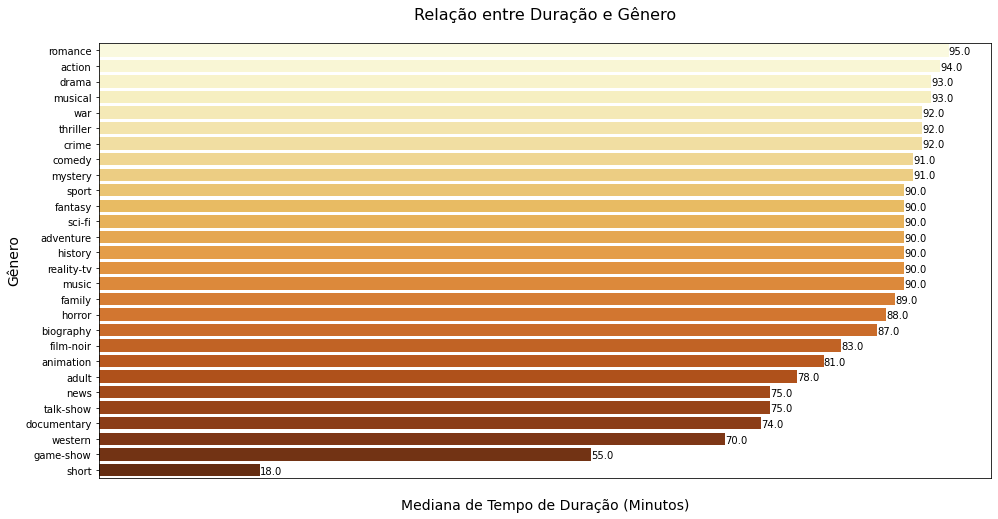

In [54]:
#Plotando o gráfico
plt.figure(figsize = (16,8))

#Barplot
sns.barplot(y = df_genero_runtime.genre, x = df_genero_runtime.runtime, orient = 'h', palette ='YlOrBr')

#Loop
for i in range(len(df_genero_runtime.index)):
    plt.text(df_genero_runtime.runtime[df_genero_runtime.index[i]],
             i + 0.25,
             round(df_genero_runtime["runtime"][df_genero_runtime.index[i]], 2))

plt.ylabel('Gênero', fontsize = 14)
plt.xlabel('\nMediana de Tempo de Duração (Minutos)', fontsize = 14)
plt.title('Relação entre Duração e Gênero\n', fontsize = 16)
plt.xticks([]) 
plt.show()

Maioria dos gêneros possui mediana de duração similar, entre 1h:20 min a 1h:30 min.  
Como esperado, o short é o gênero com menor duração.


### 8- Qual o número de filmes produzidos por país?

In [55]:
#Consulta SQL
consulta8 = '''
            SELECT region, COUNT(*) Number_of_movier 
            FROM akas JOIN titles ON
            akas.title_id = titles.title_id
            WHERE region != 'None'
            AND type = \'movie\'
            GROUP BY region           
            '''

In [56]:
#Resultado
resultado8 = pd.read_sql_query(consulta8, conn)
resultado8

,region,Number_of_movier
0,AD,22
1,AE,6831
2,AF,114
3,AG,12
4,AL,1290
...,...,...
229,YUCS,153
230,ZA,4128
231,ZM,15
232,ZRCD,2


In [57]:
#Listas auxiliares
nomes_paises = []
contagem = []

In [58]:
#Loop para obter o país de acordo com a região
for i in range(resultado8.shape[0]):
    try:
        coun = resultado8['region'].values[i]
        nomes_paises.append(pycountry.countries.get(alpha_2 = coun).name)
        contagem.append(resultado8['Number_of_movier'].values[i])
    except:
        continue

In [59]:
#Montando dataframe
df_filmes_paises = pd.DataFrame()
df_filmes_paises['country'] = nomes_paises
df_filmes_paises['Movie_Count'] = contagem
df_filmes_paises

,country,Movie_Count
0,Andorra,22
1,United Arab Emirates,6831
2,Afghanistan,114
3,Antigua and Barbuda,12
4,Albania,1290
...,...,...
208,Samoa,1
209,Yemen,14
210,South Africa,4128
211,Zambia,15


In [60]:
#Ordenando o resultado
df_filmes_paises = df_filmes_paises.sort_values(by = 'Movie_Count', ascending = False)
df_filmes_paises.head(10)

,country,Movie_Count
199,United States,314320
65,United Kingdom,160554
96,Japan,92030
63,France,85591
89,India,83398
32,Canada,79825
47,Germany,71677
58,Spain,66346
26,Brazil,66072
93,Italy,66060


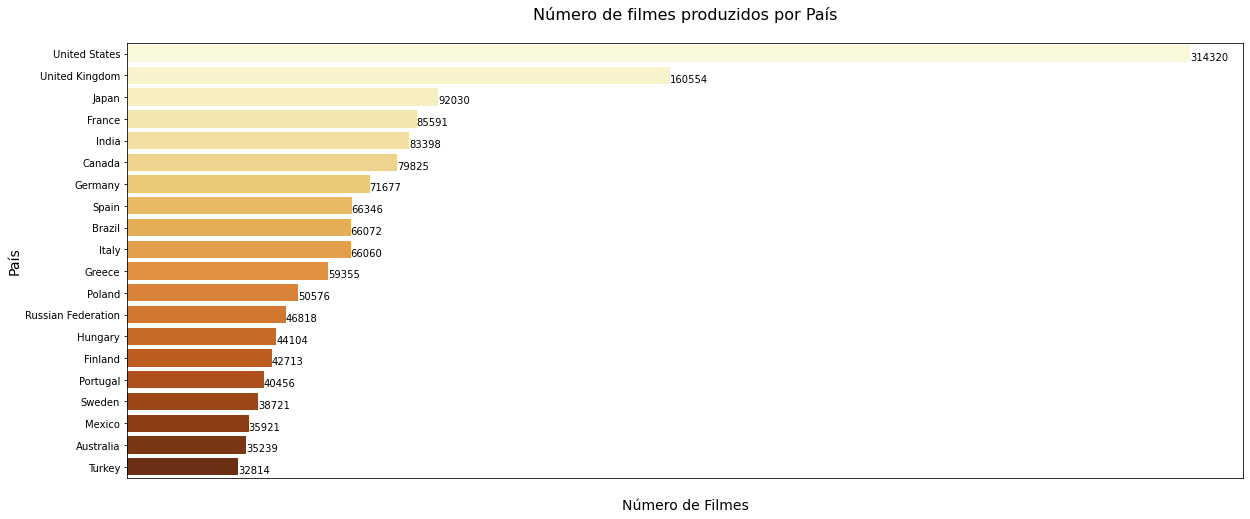

In [61]:
#Plotando o gráfico
#Figura
plt.figure(figsize= (20, 8))

#Barplot
sns.barplot(y = df_filmes_paises[:20].country, x = df_filmes_paises[:20].Movie_Count, orient = 'h', palette ='YlOrBr')

#Loop
for i in range (0,20):
    plt.text(df_filmes_paises.Movie_Count[df_filmes_paises.index[i]]-1,
             i + 0.30,
             round(df_filmes_paises['Movie_Count'][df_filmes_paises.index[i]],2))

plt.ylabel('País', fontsize = 14)
plt.xlabel('\nNúmero de Filmes', fontsize = 14)
plt.title('Número de filmes produzidos por País\n', fontsize = 16)
plt.xticks([]) 
plt.show()


Estados Unidos tem a liderança da quantidade de lançamentos de filmes em disparada, seguido de Reino Unido e Japão.   
O Brasil está em nono colocado, com quantidades similares a Espanha e Itália e a frente de países como Rússia, Finlândia, Suécia, Portugal e México. 

### 9- Quais são os Top 10 melhores filmes?

In [62]:
#Consulta SQL
consulta9 = '''
            SELECT primary_title AS Movie_Name, genres, rating
            FROM titles JOIN ratings
            ON titles.title_id = ratings.title_id
            WHERE titles.type = 'movie' AND ratings.votes >= 25000
            ORDER BY rating DESC
            LIMIT 10
            '''

In [63]:
#Resultado
top10_melhores_filmes = pd.read_sql_query(consulta9, conn)
top10_melhores_filmes

,Movie_Name,genres,rating
0,The Shawshank Redemption,Drama,9.3
1,The Chaos Class,"Comedy,Drama",9.3
2,The Godfather,"Crime,Drama",9.2
3,CM101MMXI Fundamentals,"Comedy,Documentary",9.1
4,12 Angry Men,"Crime,Drama",9.0
5,The Godfather: Part II,"Crime,Drama",9.0
6,Schindler's List,"Biography,Drama,History",9.0
7,The Lord of the Rings: The Return of the King,"Action,Adventure,Drama",9.0
8,The Dark Knight,"Action,Crime,Drama",9.0
9,Mirror Game,"Crime,Mystery,Thriller",9.0


O gênero drama apareceu em 8 dos 10 melhores filmes, enquanto na mediana de todas as notas do gênero teve uma posição intermediária.  
Documentário foi o gênero com melhor mediana mas aparece apenas uma vez no top 10 melhores.  
Essa diferença pode ser por ter muitos outros filmes com gênero drama que não foram considerados tão bons, já que também é o gênero com mais lançamento e avaliações no site, enquanto documentário pode ter tido uma avaliação mais homogênea. 

### 10- Quais são os Top 10 piores filmes?

In [64]:
#Consulta SQL
consulta10 = '''
            SELECT primary_title AS Movie_Name, genres, rating
            FROM titles JOIN ratings
            ON titles.title_id = ratings.title_id
            WHERE titles.type = 'movie' AND ratings.votes >= 25000
            ORDER BY rating ASC
            LIMIT 10
            '''

In [65]:
#Resultado
top10_piores_filmes = pd.read_sql_query(consulta10, conn)
top10_piores_filmes

,Movie_Name,genres,rating
0,Reis,"Biography,Drama",1.0
1,Cumali Ceber,Comedy,1.0
2,Sadak 2,"Action,Drama",1.1
3,Smolensk,"Drama,Thriller",1.2
4,Superbabies: Baby Geniuses 2,"Comedy,Family,Sci-Fi",1.5
5,The Cost of Deception,"Crime,Drama,History",1.5
6,Manos: The Hands of Fate,Horror,1.6
7,Justin Bieber: Never Say Never,"Documentary,Music",1.6
8,From Justin to Kelly,"Comedy,Musical,Romance",1.9
9,The Hottie & the Nottie,"Comedy,Romance",1.9


O top 10 piores possui filmes de gêneros mais diversos do que nos top 10 melhores, porém o drama é ainda o gênero que mais aparece, mostrando a grande amplitude de notas. 

## Conclusão

Com esse projeto utilizei pela primeira vez a linguagem SQL, que é extremamente utilizada para acesso aos banco de dados. Com poucas linhas foi possível extrair informações interessantes sobre as notas dos filmes no IMDB. Como projeto futuro, pretendo dar continuidade a essa pesquisa analisando especificamente e mais a fundo as obras lançadas no Brasil.